In [1]:
import numpy as np 
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stock-exchange-data/indexProcessed.csv
/kaggle/input/stock-exchange-data/indexData.csv
/kaggle/input/stock-exchange-data/indexInfo.csv


In [2]:
# Get stock quote
df = pd.read_csv('/kaggle/input/stock-exchange-data/indexData.csv', index_col='Date', parse_dates = True)
print(df.shape)
print()
print(df.info())

df.head().style.background_gradient(cmap="Spectral")

(112457, 7)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112457 entries, 1965-12-31 to 2021-06-02
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Open       110253 non-null  float64
 2   High       110253 non-null  float64
 3   Low        110253 non-null  float64
 4   Close      110253 non-null  float64
 5   Adj Close  110253 non-null  float64
 6   Volume     110253 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.9+ MB
None


,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31 00:00:00,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000
1966-01-03 00:00:00,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000
1966-01-04 00:00:00,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000
1966-01-05 00:00:00,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000
1966-01-06 00:00:00,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000


In [3]:
# Sort the data for NYA
df = df.dropna(axis=0)
df_nya = df[df['Index'] == 'NYA']
print(df_nya.shape)
print()
print(df_nya.info())
df_nya.head().style.background_gradient(cmap="Spectral")

(13947, 7)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13947 entries, 1965-12-31 to 2021-05-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      13947 non-null  object 
 1   Open       13947 non-null  float64
 2   High       13947 non-null  float64
 3   Low        13947 non-null  float64
 4   Close      13947 non-null  float64
 5   Adj Close  13947 non-null  float64
 6   Volume     13947 non-null  float64
dtypes: float64(6), object(1)
memory usage: 871.7+ KB
None


,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31 00:00:00,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000
1966-01-03 00:00:00,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000
1966-01-04 00:00:00,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000
1966-01-05 00:00:00,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000
1966-01-06 00:00:00,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000


In [4]:
# Generate a profilereport based on a pandas dataframe
#profile = ProfileReport(df_nya, title = "Pandas Profiling Report")
#profile

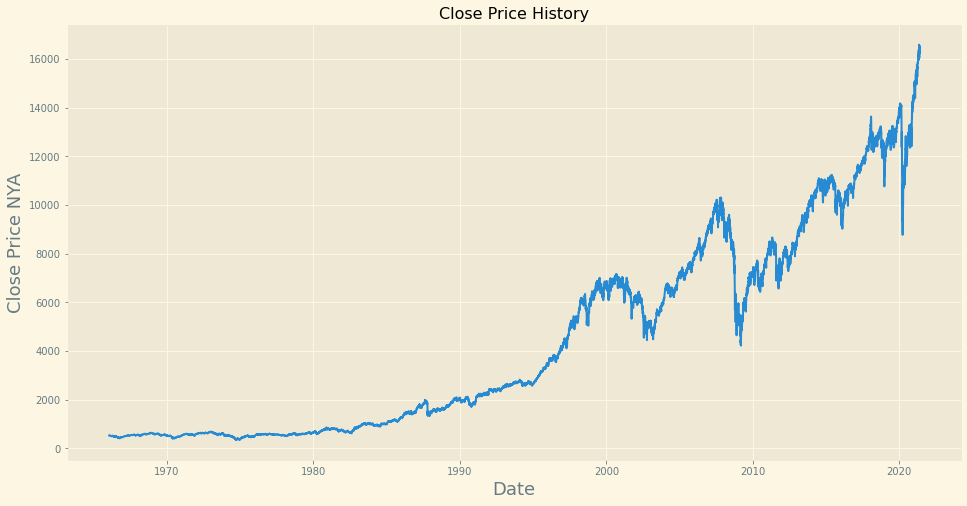

In [5]:
# Visualization
plt.style.use('Solarize_Light2')
plt.figure(figsize = (16, 8))
plt.title('Close Price History')
plt.plot(df_nya['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price NYA', fontsize = 18)
plt.show()

In [6]:
# Create a new dataframe with only the 'Close' column
df_nya = df_nya.filter(['Close'])
dataset = df_nya.values
training_data_len_1 = len(dataset) * .8
print(training_data_len_1)

# Round a number upward to its nearest integer
trainig_data_len = math.ceil(len(dataset) * .8)
print()
print(trainig_data_len)

11157.6

11158


In [7]:
dataset

array([[  528.690002],
       [  527.210022],
       [  527.840027],
       ...,
       [16451.96094 ],
       [16531.94922 ],
       [16555.66016 ]])

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01113857],
       [0.01104745],
       [0.01108624],
       ...,
       [0.991475  ],
       [0.99639958],
       [0.99785937]])

In [9]:
# Create training dataset
train_data = scaled_data[0 : trainig_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.01113857, 0.01104745, 0.01108624, 0.01128818, 0.01134666,
       0.01137929, 0.01145748, 0.01148334, 0.01142486, 0.01149012,
       0.01155476, 0.01167851, 0.01176962, 0.01169143, 0.0115683 ,
       0.01158739, 0.01169143, 0.01171791, 0.01168528, 0.01167235,
       0.0115683 , 0.01142486, 0.01116443, 0.01130788, 0.01134666,
       0.01155476, 0.01166558, 0.01163972, 0.01182811, 0.01173699,
       0.01173084, 0.01169821, 0.01155476, 0.0115486 , 0.01137252,
       0.01130788, 0.0111121 , 0.01096926, 0.0107544 , 0.01084551,
       0.0108843 , 0.01047427, 0.01016213, 0.01029203, 0.01019414,
       0.00976503, 0.00979704, 0.01005747, 0.01006424, 0.01003838,
       0.00967391, 0.0094652 , 0.00963451, 0.0097324 , 0.009882  ,
       0.01012273, 0.01021384, 0.0101098 , 0.01015536, 0.01023355])]
[0.010292034437543993]

[array([0.01113857, 0.01104745, 0.01108624, 0.01128818, 0.01134666,
       0.01137929, 0.01145748, 0.01148334, 0.01142486, 0.01149012,
       0.01155476, 0.01167851, 0.0

In [10]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(11098, 60)
(11098,)


In [11]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(11098, 60, 1)

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences = False))
model.add(Dense(50))
model.add(Dense(1))

In [13]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
# Train the model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

11098/11098 [==============================] - 73s 6ms/step - loss: 4.0977e-04


In [15]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[trainig_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[trainig_data_len: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [16]:
# Convert the data to a numpy array
x_test = np.array(x_test)
print(x_test)
print()
print(x_test.shape)

[[0.39649232 0.39617773 0.39193705 ... 0.44031891 0.44583339 0.43876003]
 [0.39617773 0.39193705 0.39940443 ... 0.44583339 0.43876003 0.44299088]
 [0.39193705 0.39940443 0.3984169  ... 0.43876003 0.44299088 0.43031623]
 ...
 [0.91913823 0.91434659 0.89958421 ... 0.9867368  0.99225864 0.98767195]
 [0.91434659 0.89958421 0.91758741 ... 0.99225864 0.98767195 0.991475  ]
 [0.89958421 0.91758741 0.91983765 ... 0.98767195 0.991475   0.99639958]]

(2789, 60)


In [17]:
# Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(2789, 60, 1)


In [18]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

array([[ 7686.1313],
       [ 7701.129 ],
       [ 7598.055 ],
       ...,
       [16473.832 ],
       [16497.574 ],
       [16550.016 ]], dtype=float32)

In [19]:
# Root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

199.3082962170917

In [20]:
train = df_nya[:trainig_data_len]
valid = df_nya[trainig_data_len:]
valid['Predictions'] = predictions
valid.head().style.background_gradient(cmap="Spectral")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,Predictions
Date,,
2010-05-03 00:00:00,7543.120117,7686.131348
2010-05-04 00:00:00,7337.250000,7701.128906
2010-05-05 00:00:00,7258.020020,7598.055176
2010-05-06 00:00:00,7011.919922,7507.550293
2010-05-07 00:00:00,6916.180176,7339.506348


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(close=None, block=None)>

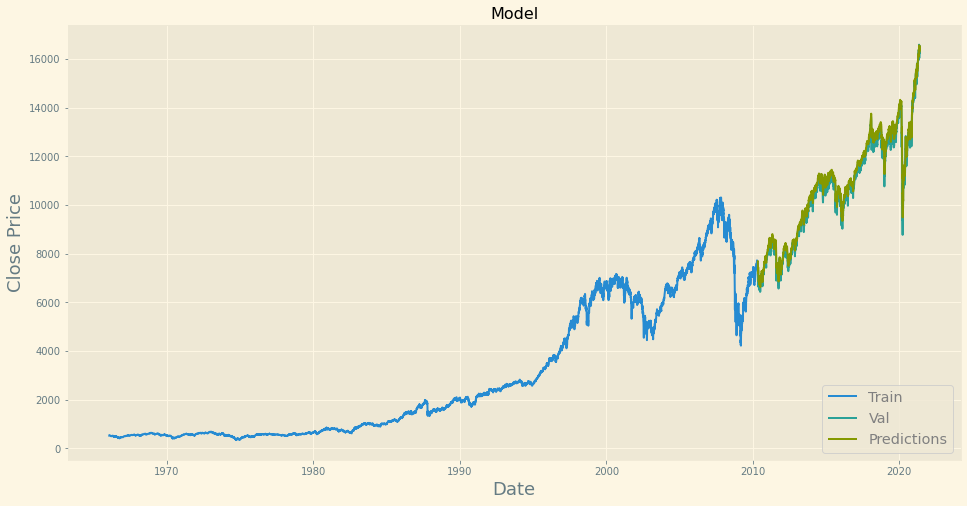

In [21]:
# Polot the data
train = df_nya[:trainig_data_len]
valid = df_nya[trainig_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.style.use('Solarize_Light2')
plt.figure(figsize = (16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right', fontsize =  'x-large', labelcolor = 'grey')
plt.show